### Import of libraries and scripts

# Use initial images and augmented images for Classification (k-Nearest-Neighbor Model)

In [1]:
import matplotlib.pyplot as plt
from skimage import io
from skimage import color
from skimage.transform import resize
import math
import numpy as np
import pandas as pd
from PIL import Image
from skimage import data, exposure
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import cv2
import glob
import os

In [2]:
# self-written scripts
import sys
sys.path.insert(0, 'Python_Scripts')

import util
import surf_hog_analysis 

---

# Use initial train.csv (based on 4 imbalanced classes in train_images) in KNN

---

### Data preparation

In [3]:
# read in the data
df = pd.read_csv('data/train_complete.csv')
# isolate only images that have 0 or 1 defect
util.isolate_single_defects(df)
# eliminate class 0 in dataframe
df2 = df.query('ClassId != 0')

In [4]:
df.groupby('ClassId')['ImageId'].count()

ClassId
0    5902
1     769
2     195
3    4759
4     516
Name: ImageId, dtype: int64

In [5]:
initial_images =[]

IMG_SIZE = 128
for image_id in df2['ImageId']:
    image = io.imread('data/single_defect_train_images/' + image_id)
    #resize images
    image_resized=cv2.resize(image,(IMG_SIZE,IMG_SIZE))
    #The input data have to be converted from 3 dimensional format to 1 dimensional format
    image_flat = image_resized.reshape(1, 3*IMG_SIZE*IMG_SIZE)
    # Data Normalization
    # Conversion to float
    image_flat=image_flat.astype('float32')
    # Normalization (In the RGB color space the red, green and blue have integer values from 0 to 255)
    image_flat = image_flat/255.0
    initial_images.append([image_id,image_flat[0]])

In [6]:
initial_images = pd.DataFrame(initial_images , columns = ['ImageId', 'flattened_images'])
initial_images.head()

,ImageId,flattened_images
0,0002cc93b.jpg,"[0.28627452, 0.28627452, 0.28627452, 0.2588235..."
1,0007a71bf.jpg,"[0.19607843, 0.19607843, 0.19607843, 0.1882353..."
2,000a4bcdd.jpg,"[0.1882353, 0.1882353, 0.1882353, 0.18431373, ..."
3,000f6bf48.jpg,"[0.19215687, 0.19215687, 0.19215687, 0.3098039..."
4,0014fce06.jpg,"[0.2901961, 0.2901961, 0.2901961, 0.28627452, ..."


In [7]:
split_initial_images = pd.DataFrame(initial_images['flattened_images'].tolist())
initial_images_complete = pd.concat([initial_images, split_initial_images], axis=1)
initial_images_complete.drop(['flattened_images'], axis=1, inplace=True)
initial_images_complete.head()

,ImageId,0,1,2,3,4,5,6,7,8,...,49142,49143,49144,49145,49146,49147,49148,49149,49150,49151
0,0002cc93b.jpg,0.286275,0.286275,0.286275,0.258824,0.258824,0.258824,0.266667,0.266667,0.266667,...,0.207843,0.219608,0.219608,0.219608,0.341176,0.341176,0.341176,0.239216,0.239216,0.239216
1,0007a71bf.jpg,0.196078,0.196078,0.196078,0.188235,0.188235,0.188235,0.184314,0.184314,0.184314,...,0.333333,0.372549,0.372549,0.372549,0.341176,0.341176,0.341176,0.341176,0.341176,0.341176
2,000a4bcdd.jpg,0.188235,0.188235,0.188235,0.184314,0.184314,0.184314,0.196078,0.196078,0.196078,...,0.301961,0.309804,0.309804,0.309804,0.305882,0.305882,0.305882,0.298039,0.298039,0.298039
3,000f6bf48.jpg,0.192157,0.192157,0.192157,0.309804,0.309804,0.309804,0.156863,0.156863,0.156863,...,0.262745,0.156863,0.156863,0.156863,0.231373,0.231373,0.231373,0.196078,0.196078,0.196078
4,0014fce06.jpg,0.290196,0.290196,0.290196,0.286275,0.286275,0.286275,0.294118,0.294118,0.294118,...,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922


In [8]:
# add classId to dataframe
initial_images_complete = pd.merge(initial_images_complete, df[['ImageId','ClassId']], on='ImageId')

In [9]:
#Split in X und Y
X = initial_images_complete.drop(['ClassId','ImageId'], axis =1)
y = initial_images_complete['ClassId']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y, random_state = 42)
print('Training data and target sizes: \n{}, {}'.format(X_train.shape,y_train.shape))
print('Test data and target sizes: \n{}, {}'.format(X_test.shape,y_test.shape))

Training data and target sizes: 
(4991, 49152), (4991,)
Test data and target sizes: 
(1248, 49152), (1248,)


### Build the model

In [10]:
# scale the data (X) and build the model
test_accuracy = []
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

classifier = KNeighborsClassifier(n_neighbors=3,algorithm='brute')
classifier.fit(X_train_scaled, y_train)


y_pred = classifier.predict(X_test_scaled)
test_accuracy = classifier.score((X_test_scaled), y_test)
print(test_accuracy)

0.8125


### Model results

[[111   5  38   0]
 [  8  25   6   0]
 [ 69  13 863   7]
 [  5   0  83  15]]


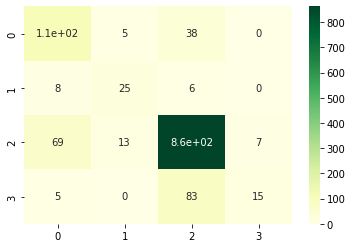

In [11]:
print(metrics.confusion_matrix(y_test,y_pred))
# Print confusion matrix
sns.heatmap(metrics.confusion_matrix(y_test, y_pred), annot=True, cmap='YlGn');

In [12]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.58      0.72      0.64       154
           2       0.58      0.64      0.61        39
           3       0.87      0.91      0.89       952
           4       0.68      0.15      0.24       103

    accuracy                           0.81      1248
   macro avg       0.68      0.60      0.59      1248
weighted avg       0.81      0.81      0.80      1248



### Conclusion:
Due to the imbalanced dataset we can predict class 3 very well. For class4 our model performs poorly. 
Overall, the quality of the model is not sufficient to use it as an upstream classifier.


In [13]:
proba = classifier.predict_proba(X_test_scaled)

In [14]:
pb = pd.DataFrame(proba, columns = ['class 1', 'class 2', 'class 3', 'class 4'])
pb

,class 1,class 2,class 3,class 4
0,0.000000,0.0,1.000000,0.0
1,0.000000,0.0,1.000000,0.0
2,0.000000,0.0,1.000000,0.0
3,0.000000,0.0,1.000000,0.0
4,0.000000,0.0,1.000000,0.0
...,...,...,...,...
1243,0.000000,0.0,1.000000,0.0
1244,0.000000,0.0,1.000000,0.0
1245,0.333333,0.0,0.666667,0.0
1246,0.000000,0.0,1.000000,0.0


In [15]:
pd_complete = pd.concat([pb, y_test.reset_index()], axis=1)

---

# Use augmented images (for training) in a k-Nearest-Neighbor Model

---

### Data preparation

In [3]:
df = pd.read_csv('data/train_complete.csv')
# isolate only images that have 0 or 1 defect
util.isolate_single_defects(df)
# eliminate class 0 in dataframe
df2 = df.query('ClassId != 0')

In [4]:
# read in and prepare augmented images for train

augmented_images =[]
augmented_labels = []
IMG_SIZE = 128
for class_id in [1,2,3,4]:
    suffix = 'c' + str(class_id)+ '/'
    directory_path = glob.glob('data/segmentation/train_aug/' + suffix)[0]
    for img_path in sorted(glob.glob(os.path.join(directory_path, "*.jpg"))):
        image_id = img_path.split('/')[-1]
        image = io.imread(img_path)
        #resize images
        image_resized=cv2.resize(image,(IMG_SIZE,IMG_SIZE))
        #The input data have to be converted from 3 dimensional format to 1 dimensional format
        image_flat = image_resized.reshape(1, 3*IMG_SIZE*IMG_SIZE)
        # Data Normalization
        # Conversion to float
        image_flat=image_flat.astype('float32')
        # Normalization (In the RGB color space the red, green and blue have integer values from 0 to 255)
        image_flat = image_flat/255.0
        augmented_images.append([image_id,image_flat[0]])
        augmented_labels.append(class_id)

In [5]:
augmented_images = pd.DataFrame(augmented_images , columns = ['ImageId', 'flattened_images'])
augmented_images.head()

,ImageId,flattened_images
0,aug_1000_7046618f6.jpg,"[0.007843138, 0.007843138, 0.007843138, 0.0901..."
1,aug_100_f4dde5dac.jpg,"[0.09411765, 0.09411765, 0.09411765, 0.0862745..."
2,aug_101_3fcd061fc.jpg,"[0.17254902, 0.17254902, 0.17254902, 0.1725490..."
3,aug_102_254c52b64.jpg,"[0.11372549, 0.11372549, 0.11372549, 0.1372549..."
4,aug_103_f7c4aaaad.jpg,"[0.12941177, 0.12941177, 0.12941177, 0.0941176..."


In [6]:
# split features of augmented images to list
split_augmented_images = pd.DataFrame(augmented_images['flattened_images'].tolist())
augmented_images_complete = pd.concat([augmented_images, split_augmented_images], axis=1)
augmented_images_complete.drop(['flattened_images'], axis=1, inplace=True)
augmented_images_complete.head()

,ImageId,0,1,2,3,4,5,6,7,8,...,49142,49143,49144,49145,49146,49147,49148,49149,49150,49151
0,aug_1000_7046618f6.jpg,0.007843,0.007843,0.007843,0.090196,0.090196,0.090196,0.203922,0.203922,0.203922,...,0.243137,0.101961,0.101961,0.101961,0.200000,0.200000,0.200000,0.231373,0.231373,0.231373
1,aug_100_f4dde5dac.jpg,0.094118,0.094118,0.094118,0.086275,0.086275,0.086275,0.145098,0.145098,0.145098,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,aug_101_3fcd061fc.jpg,0.172549,0.172549,0.172549,0.172549,0.172549,0.172549,0.172549,0.172549,0.172549,...,0.450980,0.329412,0.329412,0.329412,0.341176,0.341176,0.341176,0.321569,0.321569,0.321569
3,aug_102_254c52b64.jpg,0.113725,0.113725,0.113725,0.137255,0.137255,0.137255,0.109804,0.109804,0.109804,...,0.305882,0.270588,0.270588,0.270588,0.278431,0.278431,0.278431,0.211765,0.211765,0.211765
4,aug_103_f7c4aaaad.jpg,0.129412,0.129412,0.129412,0.094118,0.094118,0.094118,0.094118,0.094118,0.094118,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [8]:
# define X_train and y_train
X_train = augmented_images_complete.drop(['ImageId'], axis =1)
y_train = augmented_labels
y_train = pd.Series(y_train)

In [9]:
# read in and prepare images for test
initial_images =[]

IMG_SIZE = 128
for image_id in df2['ImageId']:
    image = io.imread('data/single_defect_train_images/' + image_id)
    #resize images
    image_resized=cv2.resize(image,(IMG_SIZE,IMG_SIZE))
    #The input data have to be converted from 3 dimensional format to 1 dimensional format
    image_flat = image_resized.reshape(1, 3*IMG_SIZE*IMG_SIZE)
    # Data Normalization
    # Conversion to float
    image_flat=image_flat.astype('float32')
    # Normalization (In the RGB color space the red, green and blue have integer values from 0 to 255)
    image_flat = image_flat/255.0
    initial_images.append([image_id,image_flat[0]])

In [10]:
initial_images = pd.DataFrame(initial_images , columns = ['ImageId', 'flattened_images'])
initial_images.head()

,ImageId,flattened_images
0,0002cc93b.jpg,"[0.28627452, 0.28627452, 0.28627452, 0.2588235..."
1,0007a71bf.jpg,"[0.19607843, 0.19607843, 0.19607843, 0.1882353..."
2,000a4bcdd.jpg,"[0.1882353, 0.1882353, 0.1882353, 0.18431373, ..."
3,000f6bf48.jpg,"[0.19215687, 0.19215687, 0.19215687, 0.3098039..."
4,0014fce06.jpg,"[0.2901961, 0.2901961, 0.2901961, 0.28627452, ..."


In [11]:
# split features of initial images to list
split_initial_images = pd.DataFrame(initial_images['flattened_images'].tolist())
initial_images_complete = pd.concat([initial_images, split_initial_images], axis=1)
initial_images_complete.drop(['flattened_images'], axis=1, inplace=True)
initial_images_complete = pd.merge(initial_images_complete, df[['ImageId','ClassId']], on='ImageId')
initial_images_complete.head()

,ImageId,0,1,2,3,4,5,6,7,8,...,49143,49144,49145,49146,49147,49148,49149,49150,49151,ClassId
0,0002cc93b.jpg,0.286275,0.286275,0.286275,0.258824,0.258824,0.258824,0.266667,0.266667,0.266667,...,0.219608,0.219608,0.219608,0.341176,0.341176,0.341176,0.239216,0.239216,0.239216,1
1,0007a71bf.jpg,0.196078,0.196078,0.196078,0.188235,0.188235,0.188235,0.184314,0.184314,0.184314,...,0.372549,0.372549,0.372549,0.341176,0.341176,0.341176,0.341176,0.341176,0.341176,3
2,000a4bcdd.jpg,0.188235,0.188235,0.188235,0.184314,0.184314,0.184314,0.196078,0.196078,0.196078,...,0.309804,0.309804,0.309804,0.305882,0.305882,0.305882,0.298039,0.298039,0.298039,1
3,000f6bf48.jpg,0.192157,0.192157,0.192157,0.309804,0.309804,0.309804,0.156863,0.156863,0.156863,...,0.156863,0.156863,0.156863,0.231373,0.231373,0.231373,0.196078,0.196078,0.196078,4
4,0014fce06.jpg,0.290196,0.290196,0.290196,0.286275,0.286275,0.286275,0.294118,0.294118,0.294118,...,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,3


In [12]:
# define X and Y
X = initial_images_complete.drop(['ClassId','ImageId'], axis =1)
y = initial_images_complete['ClassId']

# use a split to reduce the test set
from sklearn.model_selection import train_test_split
X_unnötig, X_test, y_unnötig, y_test = train_test_split(X,y,test_size=0.5,stratify=y, random_state = 42)
print('Training data and target sizes: \n{}, {}'.format(X_train.shape,y_train.shape))
print('Test data and target sizes: \n{}, {}'.format(X_test.shape,y_test.shape))

Training data and target sizes: 
(4000, 49152), (4000,)
Test data and target sizes: 
(3120, 49152), (3120,)


### Build the model

In [13]:
#scale the data and build the model
test_accuracy = []
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

classifier = KNeighborsClassifier(n_neighbors=3,algorithm='brute')
classifier.fit(X_train_scaled, y_train)

# make prediction
y_pred = classifier.predict(X_test_scaled)
test_accuracy = classifier.score((X_test_scaled), y_test)
print(test_accuracy)

0.47115384615384615


### Model results

[[ 309   27   43    6]
 [   9   88    0    0]
 [1042  229  991  118]
 [  79    8   89   82]]


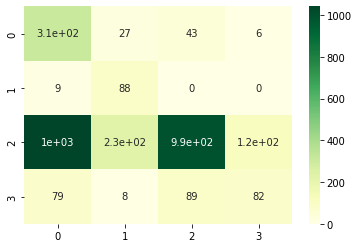

In [14]:
print(metrics.confusion_matrix(y_test,y_pred))
# Print confusion matrix
sns.heatmap(metrics.confusion_matrix(y_test, y_pred), annot=True, cmap='YlGn');

In [15]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.21      0.80      0.34       385
           2       0.25      0.91      0.39        97
           3       0.88      0.42      0.57      2380
           4       0.40      0.32      0.35       258

    accuracy                           0.47      3120
   macro avg       0.44      0.61      0.41      3120
weighted avg       0.74      0.47      0.51      3120



### Conclusion:
Now with an balanced training data set, the differences in f1 scores decreases. But we also loose our good prediction result for class 3.
Overall, the quality of the model is not sufficient to use it as an upstream classifier.

In [16]:
# make prediction with probabilities
proba = classifier.predict_proba(X_test_scaled)

In [17]:
pb = pd.DataFrame(proba, columns = ['class 1', 'class 2', 'class 3', 'class 4'])
pb

,class 1,class 2,class 3,class 4
0,0.333333,0.333333,0.333333,0.000000
1,0.000000,0.333333,0.666667,0.000000
2,1.000000,0.000000,0.000000,0.000000
3,1.000000,0.000000,0.000000,0.000000
4,1.000000,0.000000,0.000000,0.000000
...,...,...,...,...
3115,0.666667,0.000000,0.333333,0.000000
3116,1.000000,0.000000,0.000000,0.000000
3117,0.666667,0.000000,0.333333,0.000000
3118,0.333333,0.333333,0.333333,0.000000


In [18]:
pd_complete = pd.concat([pb, y_test.reset_index()], axis=1)

pd_complete.head(20)

,class 1,class 2,class 3,class 4,index,ClassId
0,0.333333,0.333333,0.333333,0.000000,28,3
1,0.000000,0.333333,0.666667,0.000000,4498,3
2,1.000000,0.000000,0.000000,0.000000,3782,1
3,1.000000,0.000000,0.000000,0.000000,4683,3
4,1.000000,0.000000,0.000000,0.000000,25,1
5,0.000000,0.000000,1.000000,0.000000,1079,3
6,1.000000,0.000000,0.000000,0.000000,4267,3
7,0.666667,0.000000,0.333333,0.000000,3856,3
8,0.000000,0.000000,1.000000,0.000000,5104,3
9,0.666667,0.000000,0.333333,0.000000,4958,3
